# Astronomaly

This notebook is designed to replicate the feature extraction methods of Astronomaly. In addition, the steps are shown individually and explained in order to provide better detail in the processes of Astronomaly. The notebook would thus ideally serve as a troubleshooting method for Astronomaly.

## Section 1: Using A Sample From Astronomaly

This section displays the contours and ellipses found by Astronomaly. The image within this section is taken directly from Astronomaly and the contours and ellipses are shown for this image. The image has already been transformed before it is obtained and as such the separate transformations can not be displayed here.

__________________________

In [1]:
from astronomaly.anomaly_detection import isolation_forest, human_loop_learning
from astronomaly.base import logging_tools
from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.data_management import image_reader
from astronomaly.dimensionality_reduction import pca
from astronomaly.feature_extraction import power_spectrum, autoencoder, shape_features
from astronomaly.feature_extraction.shape_features import find_contours, fit_ellipse, draw_contour
from astronomaly.feature_extraction.shape_features import get_ellipse_leastsq, extract_contour
from astronomaly.postprocessing import scaling
from astronomaly.preprocessing import image_preprocessing
from astronomaly.preprocessing.image_preprocessing import image_transform_sigma_clipping, image_transform_scale
from astronomaly.visualisation import tsne
from astronomaly.utils import utils

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib inline

_______________________

In [2]:
def image_transform_greyscale(img):
    """
    Simple function that combines the rgb bands into a single image.

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray
        Greyscale image

    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

_______________________

### Setting up the data

#### This subsection contains all of the relevant data and parameters that are to be specified in order for Astronomaly to run. 

Selecting the data brick to be used:

In [417]:
# coadd_id = '0260'  # Brick code
coadd_id = '0267'  # Brick code

Some default settings for Astrnomaly to use on optical data

In [418]:
list_of_files = []
window_size = 32
band_prefixes = ['z-', 'r-', 'g-']
bands_rgb = {'r': 'z-', 'g': 'r-', 'b': 'g-'}
plot_cmap = 'hot'
feature_method = 'ellipse'
dim_reduction = ''

Selecting the transform functions

In [419]:
image_transform_function = [  # image_transform_greyscale,
    # image_preprocessing.image_transform_sigma_clipping,
    # image_preprocessing.image_transform_inverse_sinh,
    # image_preprocessing.image_transform_scale
]

display_transform_function = [  # image_preprocessing.image_transform_inverse_sinh
    image_preprocessing.image_transform_scale
]

The data directory can be set up to shorten other directories and assists in sorting out the data storage. Due to the large number of bricks involved, it is much simpler to merely change the brick name than the entire directory all the time

In [420]:
data_dir = '/home/verlon/Desktop/Astronomaly/Data/Coadd_'+str(coadd_id)+'/'

In [421]:
image_dir = os.path.join(data_dir, 'Input', 'Images')
output_dir = os.path.join(data_dir, 'Output', '')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [422]:
#image_dir = os.path.join(data_dir, '0260m062', 'Input', 'Images')
#output_dir = os.path.join(data_dir, '0260m062', 'Output', '')

# if not os.path.exists(output_dir):
#    os.makedirs(output_dir)#

Selecting the catalogue (as created by the convert_tractor_catalogue function in utils.py)

In [423]:
catalogue = pd.read_csv(os.path.join(
    data_dir, 'Input', 'Catalogue', 'large_catalogue.csv'))

In [424]:
# catalogue = pd.read_csv(os.path.join(
#    data_dir, '0260m062', 'Input', 'test_catalogue_0260m062_500.csv'))

________________________________________

## Running Astronomaly

This is how Astronomaly can be run in a notebook, similar as to how it can be called in the *image_pipeline* script. This is required to obtain a sample cutout from the dataset.

Running the cell shows which fits files are read in and used as well as how many objects are found in the catalogue.

In [425]:
image_dataset = image_reader.ImageDataset(directory=image_dir,
                                          list_of_files=list_of_files,
                                          window_size=window_size,
                                          output_dir=output_dir,
                                          plot_square=False,
                                          transform_function=image_transform_function,
                                          display_transform_function=display_transform_function,
                                          plot_cmap=plot_cmap,
                                          catalogue=catalogue,
                                          band_prefixes=band_prefixes,
                                          bands_rgb=bands_rgb)

/home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Output/astronomaly.log
Now switching to new log file:
/home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Output/astronomaly.log
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m055-image.fits.fz...


2020-10-21 12:48:58,308 - WARNING - FITSFixedWarning: 'datfix' made the change 'Set DATE-REF to '1858-11-17' from MJD-REF'.


Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m057-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m060-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m062-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m065-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m067-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m092-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/Coadd_0267/Input/Images/z-legacysurvey-0267m095-image.fits.fz...
Done!
Reading image data from /home/verlon/Desktop/Astronomaly/Data/C

__________________________

This is where a sample is selected and it has yet to be transformed. To see the indices applicable, use :  *image_dataset.metadata.index*

In [426]:
image_dataset.metadata.index

Index(['2', '5', '10', '21', '33', '35', '40', '103', '105', '111', '114',
       '129', '153', '154', '155', '157', '174', '226', '262', '32852'],
      dtype='object')

These indices are used to obtain a given sample of data as follows:

In [441]:
ind = '2'  # ind = '105'

In [442]:
# Interesting failure for this one: ind = '32852'

In [443]:
# this fails at 90th perc.. where it does not find the first contour : ind = '567'

__________

### Original Image

This is the image as returned by the *get_sample* function. This image is cutout from the fits files directly and is unchanged at this stage. 

In [444]:
image_original = image_dataset.get_sample(ind)

*OPTIONAL* : The image shape is shown here for more information. The first part (32,32) inndicates the amount of pixels there are in the image. This forms an array of data with the same size. The last part indicates how many channels or bands there are. The 3 here corresponds to the three optical bands in the DECaLS data: g, r and z. The individual bands are displayed below for informational purposes.

In [445]:
print('Image Shape : ', np.shape(image_original))
print()
print('Image Dimensions : ', np.shape(image_original[:, :, 0]))
print()
print('Number of Channels : ', len(image_original[0, 0, :]))

Image Shape :  (32, 32, 3)

Image Dimensions :  (32, 32)

Number of Channels :  3


2020-10-21 12:49:38,546 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

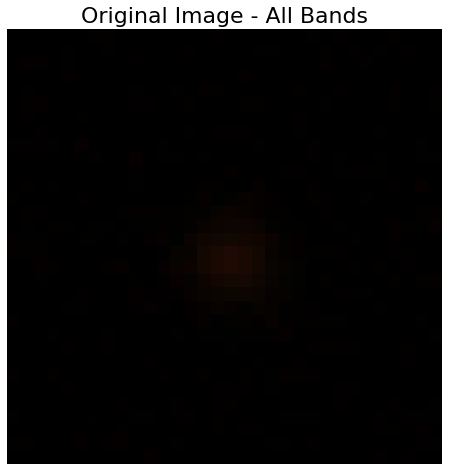

In [446]:
plt.figure(figsize=(8, 8))
plt.title('Original Image - All Bands', fontsize=22)
plt.imshow(image_original)
plt.axis('off')

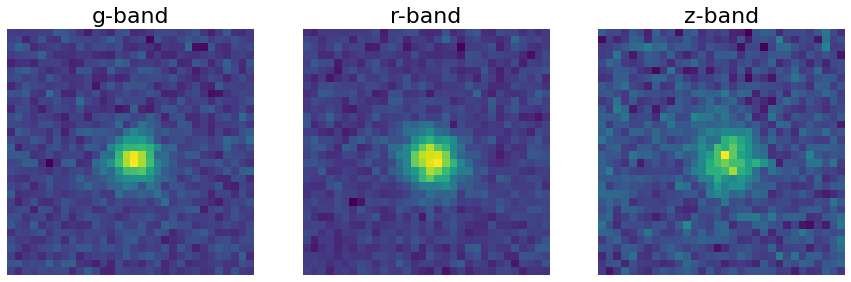

In [447]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 3, 1)
plt.imshow(image_original[:, :, 0])
plt.gca().set_title('g-band', fontsize=22)
plt.axis('off')

f.add_subplot(1, 3, 2)
plt.imshow(image_original[:, :, 1])
plt.gca().set_title('r-band', fontsize=22)
plt.axis('off')

f.add_subplot(1, 3, 3)
plt.imshow(image_original[:, :, 2])
plt.gca().set_title('z-band', fontsize=22)
plt.axis('off')

plt.show(block=True)

____________________

## Applying The Image Transformation Functions

### First Scale Transform

The Scale Transfrom function rescales the values of the array so that they lie between 0 and 1. This is also the first scale transform applied (hence first scale transform) and is applied on each channel individually. This simplifies further proceedings. Again, the individual bands are displayed below for informational purposes.

In [448]:
image_transform_one = image_transform_scale(image_original)

(-0.5, 31.5, 31.5, -0.5)

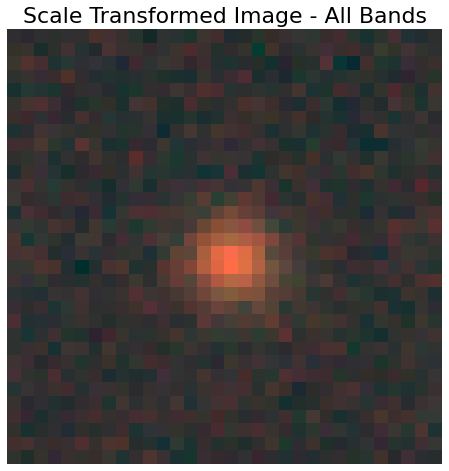

In [449]:
plt.figure(figsize=(8, 8))
plt.title('Scale Transformed Image - All Bands', fontsize=22)
plt.imshow(image_transform_one)
plt.axis('off')

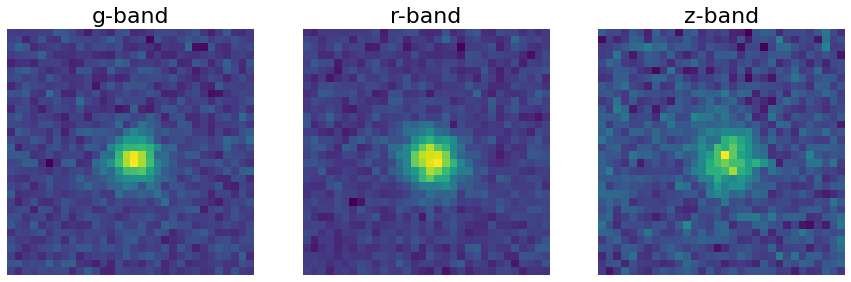

In [450]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 3, 1)
plt.imshow(image_transform_one[:, :, 0])
plt.gca().set_title('g-band', fontsize=22)
plt.axis('off')

f.add_subplot(1, 3, 2)
plt.imshow(image_transform_one[:, :, 1])
plt.gca().set_title('r-band', fontsize=22)
plt.axis('off')

f.add_subplot(1, 3, 3)
plt.imshow(image_transform_one[:, :, 2])
plt.gca().set_title('z-band', fontsize=22)
plt.axis('off')

plt.show(block=True)

______________

### Greyscale Image

The Greyscale function uses OpenCvs colour converter to convert each separate image channel to a specific colour. The channels are then combined to create a single channel image that is *greyscale* and contains information from all three separate bands. This allows more information to be used compared to using a single channel only.

In [451]:
image_grey = cv2.cvtColor(image_transform_one, cv2.COLOR_BGR2GRAY)

(-0.5, 31.5, 31.5, -0.5)

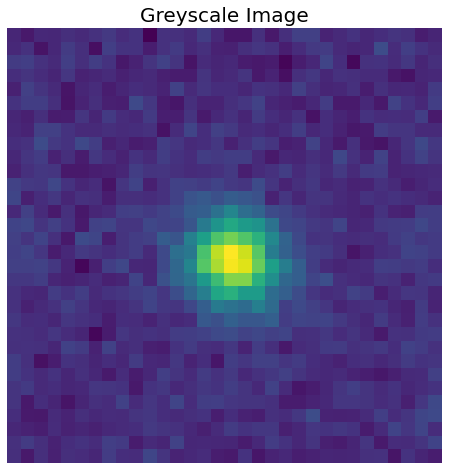

In [452]:
plt.figure(figsize=(8, 8))
plt.title('Greyscale Image', fontsize=20)
plt.imshow(image_grey)
plt.axis('off')

___________________________

### Sigma Clipping

The Sigma Clipping function is used to remove noise surrounding the object in question. It also serves in providing an 'outline' of the object in question. Details of how sigma clipping works are left out of this notebook for simplicity.

In [453]:
image_sigma_clipped = image_transform_sigma_clipping(image_grey)

(-0.5, 31.5, 31.5, -0.5)

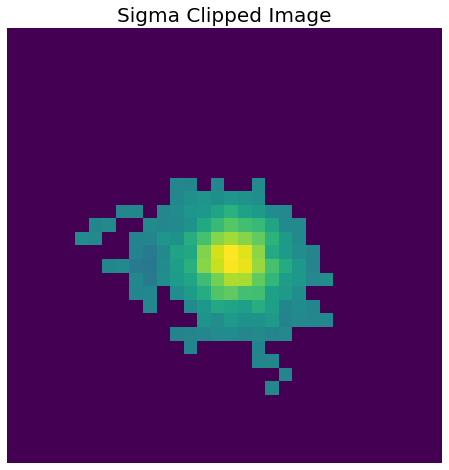

In [454]:
plt.figure(figsize=(8, 8))
plt.title('Sigma Clipped Image', fontsize=20)
plt.imshow(image_sigma_clipped)
plt.axis('off')

______________________

### Second Scale Transform

The function is the same as the first scale transform. It is applied here because the sigma clipping and the greyscale functions change the values of the arrays. This is the final transform applied and it is thus ideal to have the array values between 0 and 1 for machine learning purposes.

In [455]:
image_transform_two = image_transform_scale(image_sigma_clipped)

(-0.5, 31.5, 31.5, -0.5)

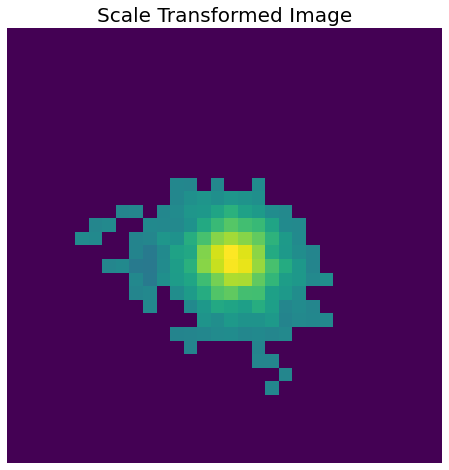

In [456]:
plt.figure(figsize=(8, 8))
plt.title('Scale Transformed Image', fontsize=20)
plt.imshow(image_transform_two)
plt.axis('off')

_____________

### Combined effects

This image shows all of the previous steps one after the other for a sample cutout.

2020-10-21 12:49:45,083 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


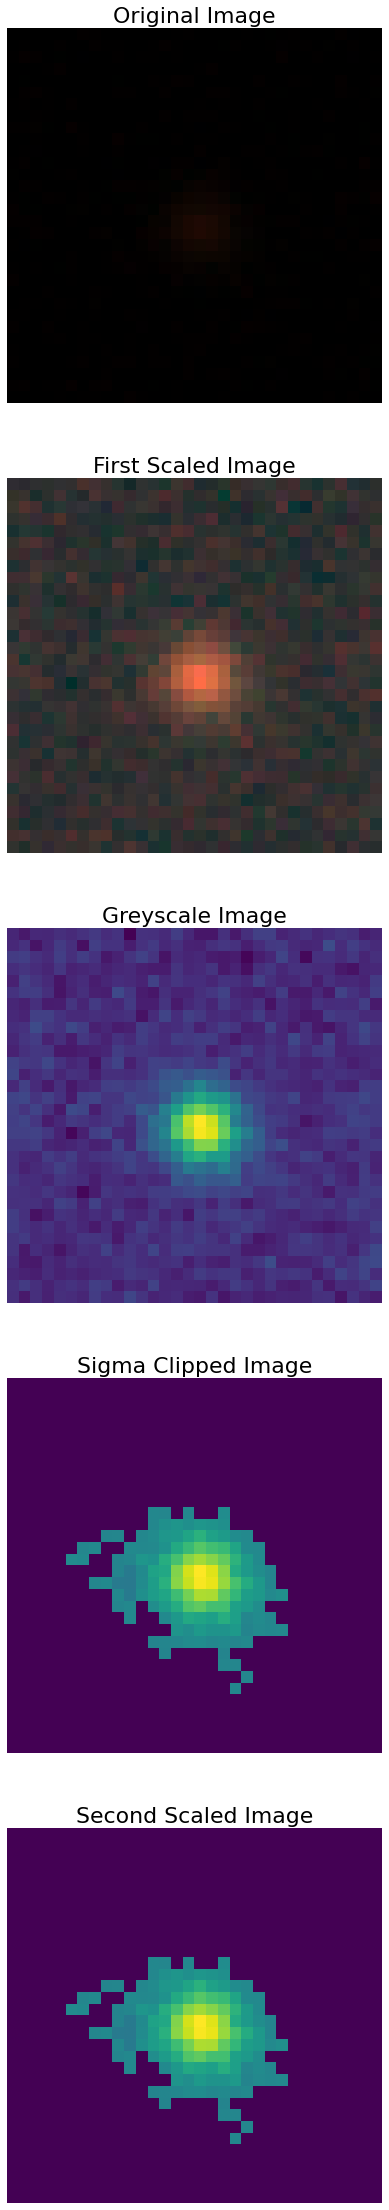

In [457]:
f = plt.figure(figsize=(50, 40))

f.add_subplot(5, 1, 1)
plt.imshow(image_original)
plt.gca().set_title('Original Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 2)
plt.imshow(image_transform_one)
plt.gca().set_title('First Scaled Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 3)
plt.imshow(image_grey)
plt.gca().set_title('Greyscale Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 4)
plt.imshow(image_sigma_clipped)
plt.gca().set_title('Sigma Clipped Image', fontsize=22)
plt.axis('off')

f.add_subplot(5, 1, 5)
plt.imshow(image_transform_two)
plt.gca().set_title('Second Scaled Image', fontsize=22)
plt.axis('off')

plt.show(block=True)

### Rescaled Image

This function resamples and rescales and image to a higher pixel resolution. This function is required at times to provide more data points when fitting the ellipses. An example of its functionality is shown here on both the original image (can sometimes be difficult to actually see the image) and on the previous image.

In [458]:
scale_percent = [100, 125, 150, 175]

In [459]:
image = image_transform_two

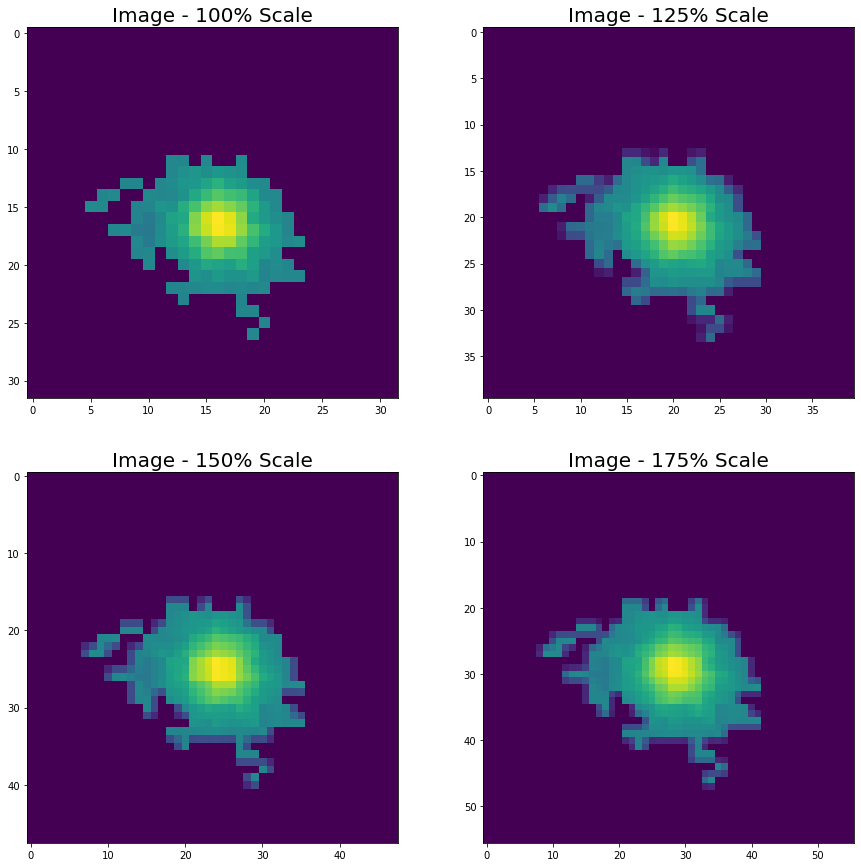

In [460]:
resized_images = []
for i in scale_percent:
    width = int(image.shape[1] * i / 100)
    height = int(image.shape[0] * i / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    resized_images.append(resized)

f = plt.figure(figsize=(15, 15))

f.add_subplot(2, 2, 1)
plt.imshow(resized_images[0])
plt.gca().set_title('Image - ' +
                    str(scale_percent[0]) + '% Scale', fontsize=20)

f.add_subplot(2, 2, 2)
plt.imshow(resized_images[1])
plt.gca().set_title('Image - ' +
                    str(scale_percent[1]) + '% Scale', fontsize=20)

f.add_subplot(2, 2, 3)
plt.imshow(resized_images[2])
plt.gca().set_title('Image - ' +
                    str(scale_percent[2]) + '% Scale', fontsize=20)

f.add_subplot(2, 2, 4)
plt.imshow(resized_images[3])
plt.gca().set_title('Image - ' +
                    str(scale_percent[3]) + '% Scale', fontsize=20)

plt.show(block=True)

_________________

### Percentiles and Scale Range

Select the percentiles to be used. These percentiles divide the image into regions based on the image array values. It is these percentiles that determine the location of the contours that are to be drawn. The scale range supplied provides the range of scale over which the image can be resampled in order to determine the contours and ellipses.

In [461]:
percentiles = [90, 80, 70, 60, 50, 0]
print('Percentiles Used :', percentiles)
print()

scale = [i for i in np.arange(100, 201, 1)]
print('Scale Range Used : From 100 to 200 in increments of 1%')

Percentiles Used : [90, 80, 70, 60, 50, 0]

Scale Range Used : From 100 to 200 in increments of 1%


___________________

#### This is the function that reads in the percentiles on the relevant image, obtains the contours and finds the corresponding ellipses to these contours.

In [462]:
image = image_transform_two

percentiles = np.sort(percentiles)[::-1]

feats = []
threshold = []
all_contours = []


x0 = y0 = -1
x_cent = image.shape[0] // 2
y_cent = image.shape[1] // 2

if np.all(image == 0):
    failed = True
    failure_message = "Invalid cutout for feature extraction"
else:
    failed = False
    failure_message = ""

stop = False

for a in scale:
    print('Resize Image to scale : ', a, '%')
    drawn_contours = []
    all_ellipses = []
    lst = []

    for p in percentiles:
        lst.append(p)
        width = int(image.shape[1] * a / 100)
        height = int(image.shape[0] * a / 100)
        dim = (width, height)
        resize = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

        if failed:
            contours = []
        else:
            thresh = np.percentile(resize[resize > 0], p)
            contours, hierarchy = find_contours(resize, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))

        if len(contours) != 0:
            for k in range(len(contours)):
                M = cv2.moments(contours[k])
                try:
                    x_contours[k] = int(M["m10"] / M["m00"])
                    y_contours[k] = int(M["m01"] / M["m00"])
                except ZeroDivisionError:
                    pass
            if x0 == -1:
                x_diff = x_contours - x_cent
                y_diff = y_contours - y_cent
            else:
                x_diff = x_contours - x0
                y_diff = y_contours - y0

            # Will try to find the CLOSEST contour to the central one
            r_diff = np.sqrt(x_diff**2 + y_diff**2)

            ind = np.argmin(r_diff)

            if x0 == -1:
                x0 = x_contours[ind]
                y0 = y_contours[ind]

            c = contours[ind]

            params = get_ellipse_leastsq(c, resize)

            # Limiting condition for OpenCVs fitEllipse. Ensures a
            # minimum of 5 points are found
            if len(c) < 5:
                long_enough = False
                print('Loop broken due to insufficient points')
                print()
                break

            ellipse_arr, param = fit_ellipse(
                c, resize, return_params=True, filled=False)

            if np.any(np.isnan(params)):
                failed = True
            else:
                if params[3] == 0 or params[4] == 0:
                    aspect = 1
                else:
                    aspect = params[4] / params[3]

                if aspect < 1:
                    aspect = 1 / aspect
                if aspect > 100:
                    aspect = 1

                new_params = params[:3] + [aspect] + [params[-1]]
                feats.append(new_params)

            all_ellipses.append(ellipse_arr)
            all_contours.append(c)

            draw = draw_contour(c, resize)
            drawn_contours.append(draw)

        else:
            failed = True
            failure_message = "No contour found"

        if failed:
            feats.append([np.nan] * 5)
            logging_tools.log(failure_message)

        print('Number of contours found :', len(all_ellipses))

        if len(lst) == len(percentiles):
            print('All necessary contours found')
            stop = True

    if stop:
        break

    print()

Resize Image to scale :  100 %
Number of contours found : 1
Number of contours found : 2
Number of contours found : 3
Number of contours found : 4
Number of contours found : 5
Number of contours found : 6
All necessary contours found


#### All of the contours and the correscponding ellipses are plotted here. The cmap is set to hot to better visualise the contours and ellipses.

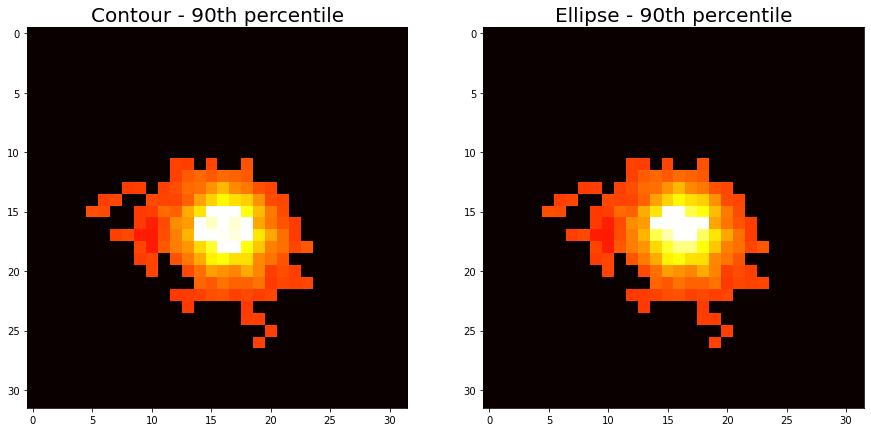

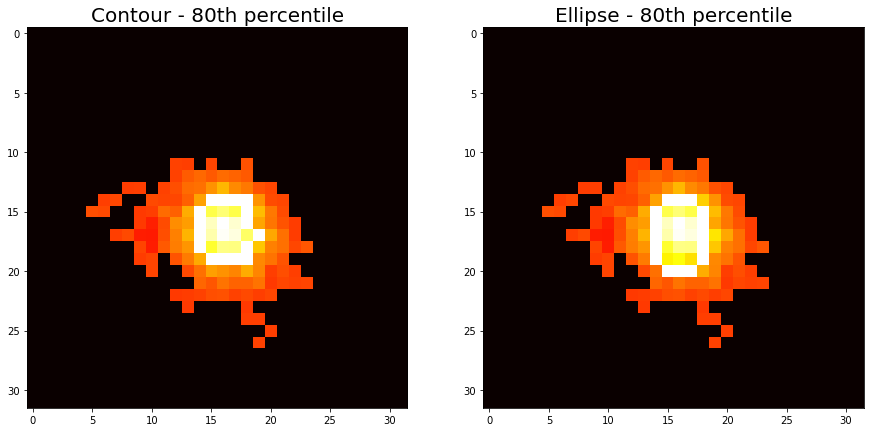

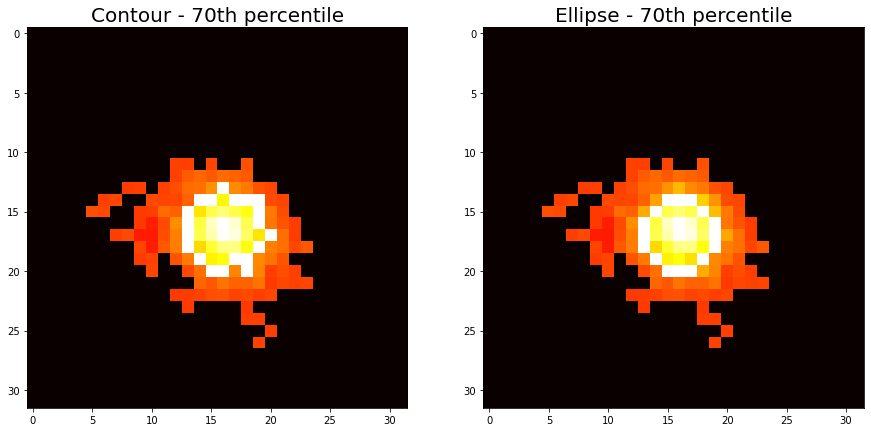

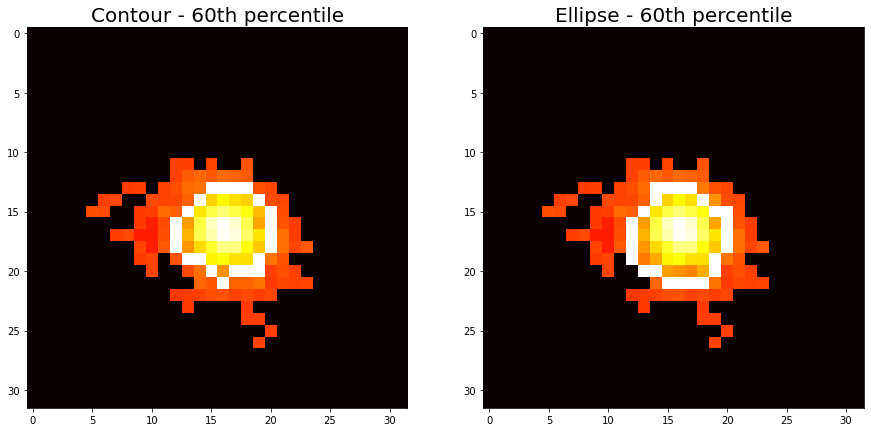

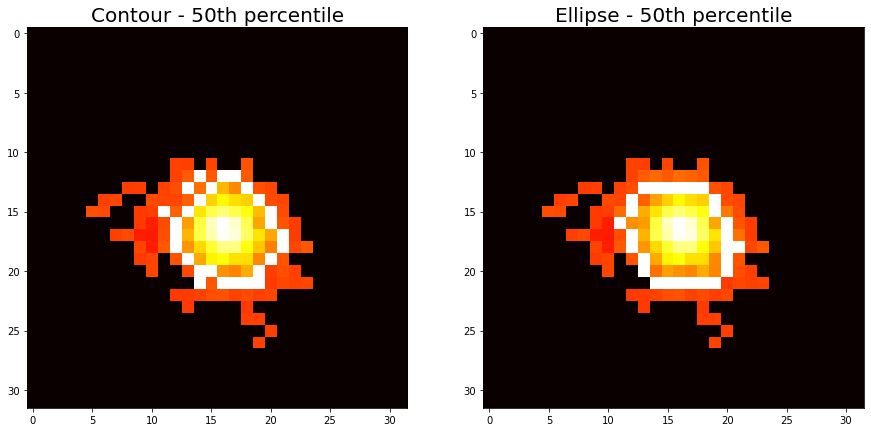

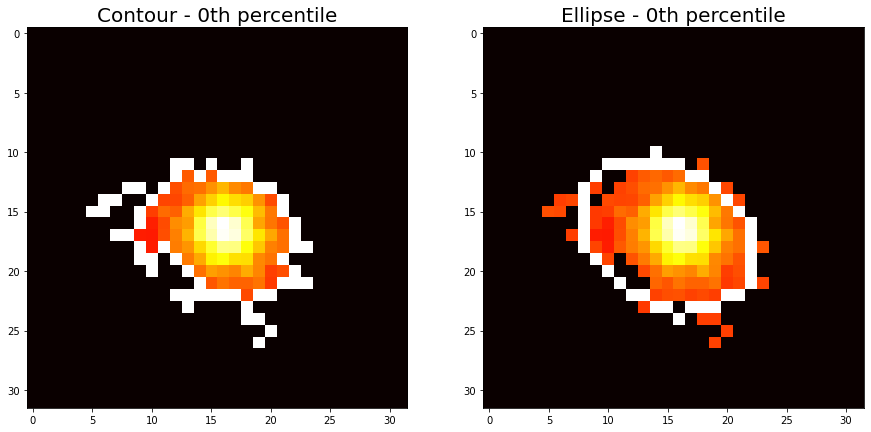

In [463]:
%matplotlib inline

for i in range(len(drawn_contours)):
    f = plt.figure(figsize=(15, 15))

    f.add_subplot(1, 2, 1)
    plt.imshow(drawn_contours[i], cmap='hot')
    plt.gca().set_title('Contour - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    f.add_subplot(1, 2, 2)
    plt.imshow(all_ellipses[i], cmap='hot')
    plt.gca().set_title('Ellipse - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    plt.show(block=True)

## Works: Different Size Image Each Time

In [464]:
image = image_transform_two

percentiles = np.sort(percentiles)[::-1]

c = []
feats = []
threshold = []
all_contours = []
all_ellipses = []

x0 = y0 = -1
x_cent = image.shape[0] // 2
y_cent = image.shape[1] // 2

if np.all(image == 0):
    failed = True
    failure_message = "Invalid cutout for feature extraction"
else:
    failed = False
    failure_message = ""

too_short = False
contour_length = []
drawn_contours = []

for p in percentiles:
    if failed:
        contours = []

    else:
        thresh = np.percentile(image[image > 0], p)
        contours_1, hierarchy = find_contours(image, thresh)

        x_contours = np.zeros(len(contours_1))
        y_contours = np.zeros(len(contours_1))

    if too_short:
        scale_percent = 105
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

        thresh = np.percentile(image[image > 0], p)
        contours_1, hierarchy = find_contours(image, thresh)

        x_contours = np.zeros(len(contours_1))
        y_contours = np.zeros(len(contours_1))

    if len(contours_1) != 0:
        for k in range(len(contours_1)):
            M = cv2.moments(contours_1[k])
            try:
                x_contours[k] = int(M["m10"] / M["m00"])
                y_contours[k] = int(M["m01"] / M["m00"])
            except ZeroDivisionError:
                pass
        if x0 == -1:
            x_diff = x_contours - x_cent
            y_diff = y_contours - y_cent
        else:
            x_diff = x_contours - x0
            y_diff = y_contours - y0

        # Will try to find the CLOSEST contour to the central one
        r_diff = np.sqrt(x_diff**2 + y_diff**2)

        ind = np.argmin(r_diff)

        if x0 == -1:
            x0 = x_contours[ind]
            y0 = y_contours[ind]

        c_1 = contours_1[ind]

        params = get_ellipse_leastsq(c_1, image)

        # Params return in this order:
        # residual, x0, y0, maj_axis, min_axis, theta
        if np.any(np.isnan(params)):
            failed = True
        else:
            if params[3] == 0 or params[4] == 0:
                aspect = 1
            else:
                aspect = params[4] / params[3]

            if aspect < 1:
                aspect = 1 / aspect
            if aspect > 100:
                aspect = 1

            new_params = params[:3] + [aspect] + [params[-1]]
            feats.append(new_params)

    else:
        failed = True
        failure_message = "No contour found"

    if failed:
        feats.append([np.nan] * 5)
        logging_tools.log(failure_message)

    contour_length.append(len(c_1))

    ellipse_arr, param = fit_ellipse(
        c_1, image, return_params=True, filled=False)

    all_ellipses.append(ellipse_arr)
    all_contours.append(c_1)

    draw = draw_contour(c_1, image)
    drawn_contours.append(draw)

    print(len(c_1))

    if any(contour_length) < 5:
        too_short = True

    else:
        too_short = False

9
12
15
23
18
36


for i in range(len(contour_length)):
    if contour_length[i] > 5:
        too_short = False
        print(too_short)
    else:
        too_short = True
        print(too_short)

In [465]:
for i in range(len(percentiles)):
    print(np.shape(drawn_contours[i]))

(32, 32)
(33, 33)
(34, 34)
(35, 35)
(36, 36)
(37, 37)


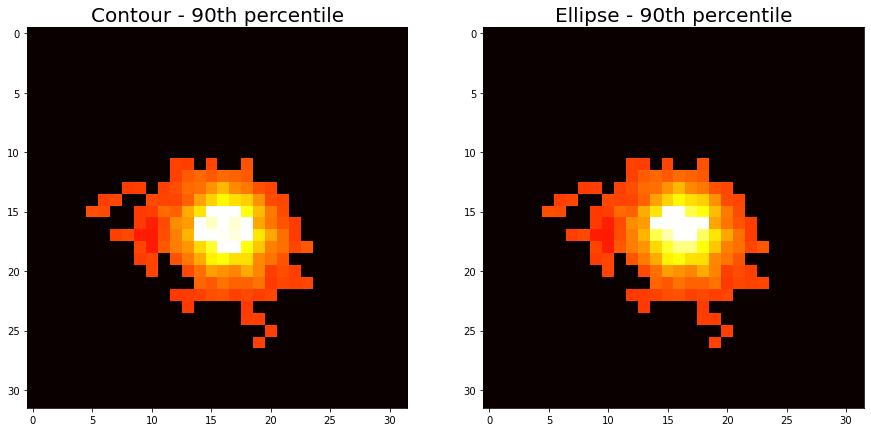

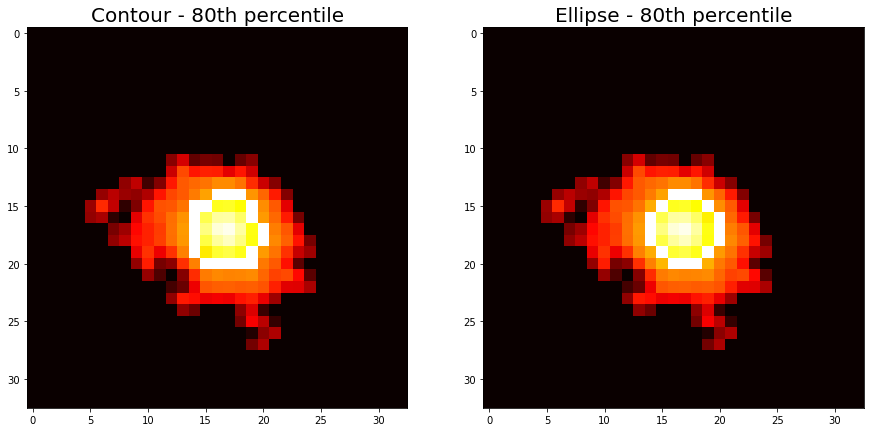

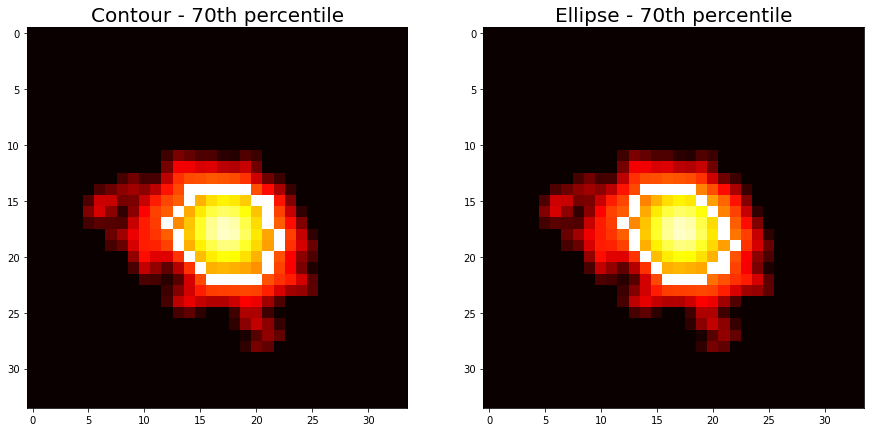

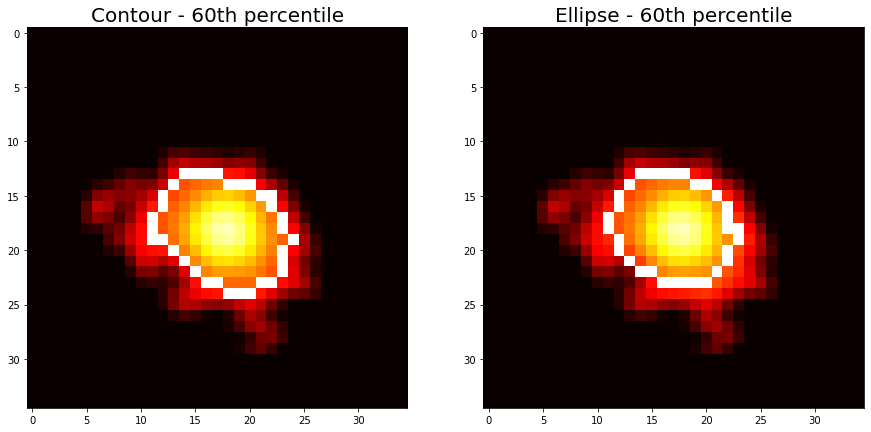

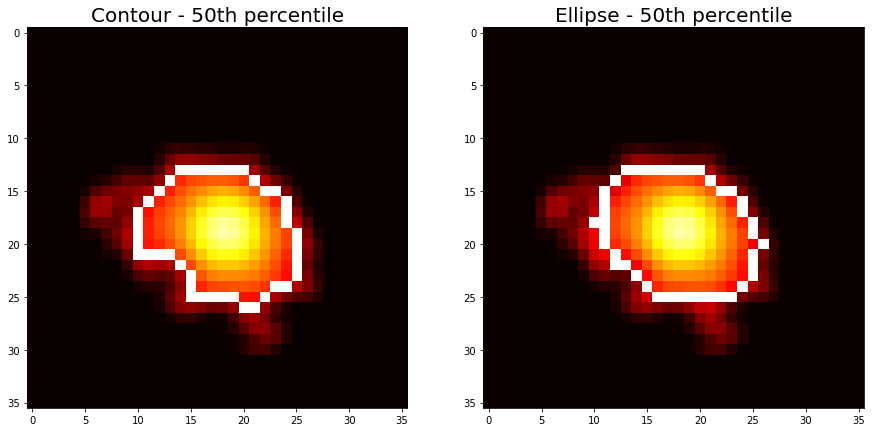

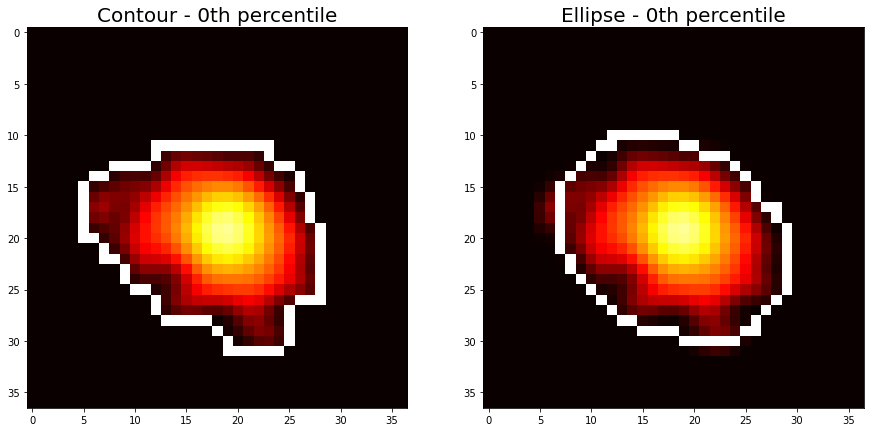

In [466]:
%matplotlib inline

for i in range(len(percentiles)):
    f = plt.figure(figsize=(15, 15))

    f.add_subplot(1, 2, 1)
    plt.imshow(drawn_contours[i], cmap='hot')
    plt.gca().set_title('Contour - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    f.add_subplot(1, 2, 2)
    plt.imshow(all_ellipses[i], cmap='hot')
    plt.gca().set_title('Ellipse - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

    plt.show(block=True)

_______________

## Section 2: Using A Cutout From The Legacy Skyviewer.

This section applies the same procedure as Astronomaly on a cutout from the Legacy Skyviewer. The image transformation process can thus be displayed step by step. This assists in troubleshooting if needed.

________________

Loading the images is done by opening the relevant fits file and reading the data.

In [467]:
cutout = '/home/verlon/Desktop/Astronomaly/Data/Coadd_0260/0260m062/Input/Failed Images/cutout_26.0835_-6.3682.fits'

In [473]:
image = fits.getdata(cutout)

_________

### Original Image

This small section splits the image into the separate channels and recombines them so that they are in the same order as that of the *get_sample* function of Astronomaly.

In [469]:
one = image[0,:,:] # g-band - blue b
two = image[1,:,:] # r-band - green g
three = image[2,:,:] # z-band - red r

In [474]:
rgb_image = np.dstack((three,two,one)) #RGB IMAGE
bgr_image = np.dstack((one,two,three)) #BGR IMAGE
image_original = rgb_image

___________

The original image and the three separate bands are displayed here.

2020-10-21 12:49:57,794 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

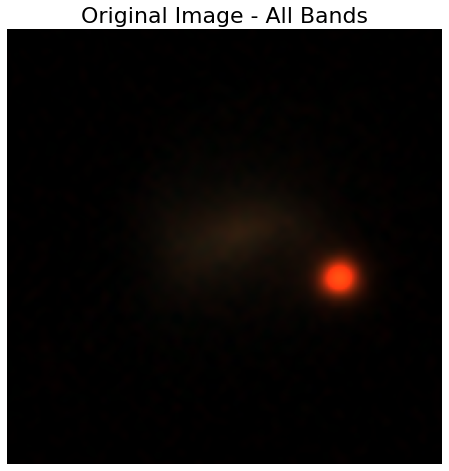

In [471]:
plt.figure(figsize=(8, 8))
plt.title('Original Image - All Bands', fontsize=22)
plt.imshow(image_original)
plt.axis('off')

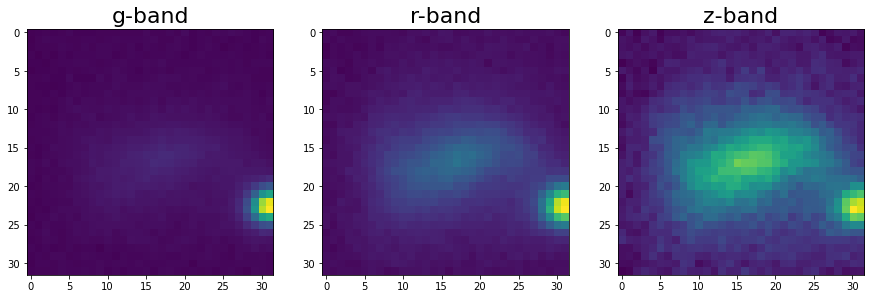

In [416]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 3, 1)
plt.imshow(image_original[:, :, 0])
plt.gca().set_title('g-band', fontsize=22)

f.add_subplot(1, 3, 2)
plt.imshow(image_original[:, :, 1])
plt.gca().set_title('r-band', fontsize=22)

f.add_subplot(1, 3, 3)
plt.imshow(image_original[:, :, 2])
plt.gca().set_title('z-band', fontsize=22)

plt.show(block=True)

_________________

## Applying The Image Transformation Functions

### First Scale Transform

#### Greyscale Transform

The first transformation done is the greyscale transform. This is required so as to join all three separate bands together and thus minimizes data loss.

In [57]:
image_grey = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

2020-10-21 09:41:02,720 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2020-10-21 09:41:02,776 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


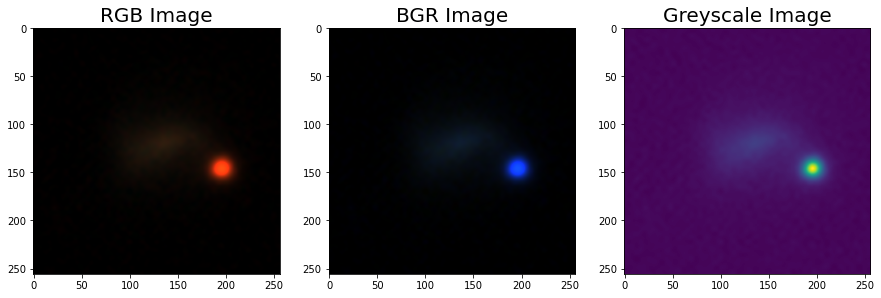

In [58]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.gca().set_title('RGB Image', fontsize=20)

f.add_subplot(1, 3, 2)
plt.imshow(bgr_image)
plt.gca().set_title('BGR Image', fontsize=20)

f.add_subplot(1, 3, 3)
plt.imshow(image_grey)
plt.gca().set_title('Greyscale Image', fontsize=20)

plt.show(block=True)

#### Sigma Clipping

Sigma clipping removes background noise as well as compensates for nearby objects. It is needed to remove any interference.

In [59]:
image_sigma_clipped = image_transform_sigma_clipping(image_grey)

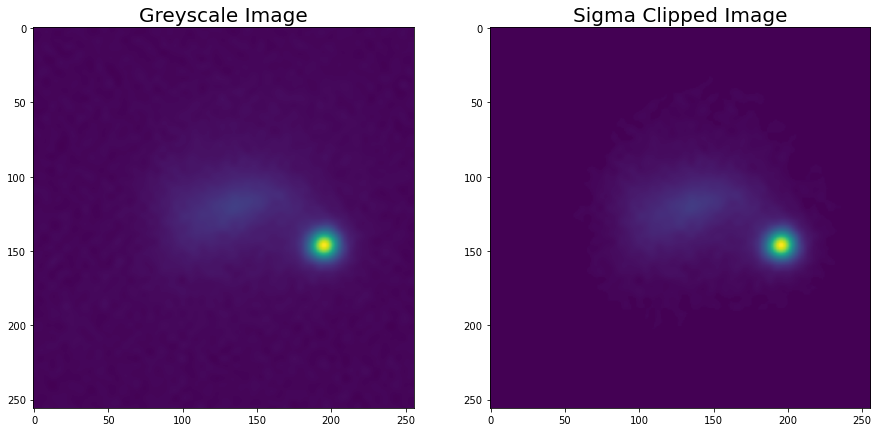

In [60]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 2, 1)
plt.imshow(image_grey)
plt.gca().set_title('Greyscale Image', fontsize=20)

f.add_subplot(1, 2, 2)
plt.imshow(image_sigma_clipped)
plt.gca().set_title('Sigma Clipped Image', fontsize=20)

plt.show(block=True)

#### Scale Transform

This transformation normalises the image so that the array values are between 0 and 1. This is useful for deep learning.

In [61]:
image_transform = image_transform_scale(image_sigma_clipped)

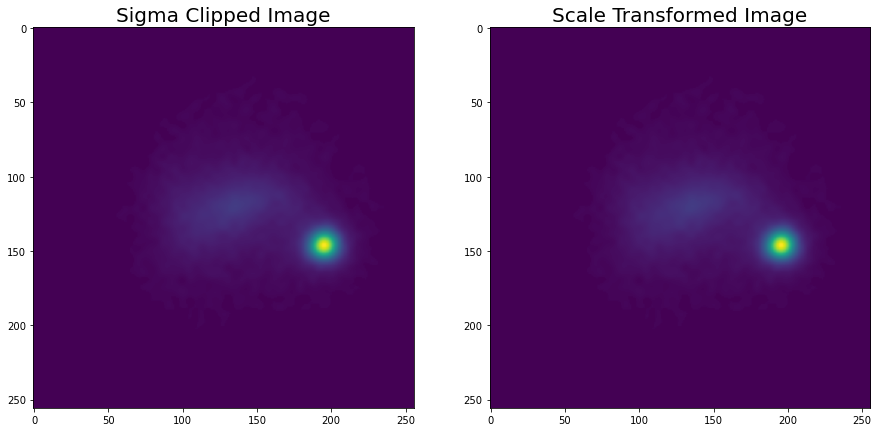

In [62]:
f = plt.figure(figsize=(15, 15))

f.add_subplot(1, 2, 1)
plt.imshow(image_sigma_clipped)
plt.gca().set_title('Sigma Clipped Image', fontsize=20)

f.add_subplot(1, 2, 2)
plt.imshow(image_transform)
plt.gca().set_title('Scale Transformed Image', fontsize=20)

plt.show(block=True)

In [72]:
image = image_transform

_________________________

In [73]:
percentiles = np.sort(percentiles)[::-1]

feats = []
threshold = []
all_contours = []


x0 = y0 = -1
x_cent = image.shape[0] // 2
y_cent = image.shape[1] // 2

if np.all(image == 0):
    failed = True
    failure_message = "Invalid cutout for feature extraction"
else:
    failed = False
    failure_message = ""

stop = False

for a in scale:
    print('Resize Image to scale : ', a,'%')
    drawn_contours = []
    all_ellipses = []
    lst = []
    
    for p in percentiles:
        lst.append(p)
        width = int(image.shape[1] * a / 100)
        height = int(image.shape[0] * a / 100)
        dim = (width, height)
        resize = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

        if failed:
            contours = []
        else:
            thresh = np.percentile(resize[resize > 0], p)
            contours, hierarchy = find_contours(resize, thresh)

            x_contours = np.zeros(len(contours))
            y_contours = np.zeros(len(contours))

        if len(contours) != 0:
            for k in range(len(contours)):
                M = cv2.moments(contours[k])
                try:
                    x_contours[k] = int(M["m10"] / M["m00"])
                    y_contours[k] = int(M["m01"] / M["m00"])
                except ZeroDivisionError:
                    pass
            if x0 == -1:
                x_diff = x_contours - x_cent
                y_diff = y_contours - y_cent
            else:
                x_diff = x_contours - x0
                y_diff = y_contours - y0

            # Will try to find the CLOSEST contour to the central one
            r_diff = np.sqrt(x_diff**2 + y_diff**2)

            ind = np.argmin(r_diff)

            if x0 == -1:
                x0 = x_contours[ind]
                y0 = y_contours[ind]

            c = contours[ind]

            params = get_ellipse_leastsq(c, resize)
            
            # Limiting condition for OpenCVs fitEllipse. Ensures a 
            # minimum of 5 points are found
            if len(c) < 5:
                long_enough = False
                print('Loop broken due to insufficient points')
                print()
                break
        
            ellipse_arr, param = fit_ellipse(
                c, resize, return_params=True, filled=False)
            
            if np.any(np.isnan(params)):
                failed = True
            else:
                if params[3] == 0 or params[4] == 0:
                    aspect = 1
                else:
                    aspect = params[4] / params[3]

                if aspect < 1:
                    aspect = 1 / aspect
                if aspect > 100:
                    aspect = 1

                new_params = params[:3] + [aspect] + [params[-1]]
                feats.append(new_params)

            all_ellipses.append(ellipse_arr)
            all_contours.append(c)

            draw = draw_contour(c, resize)
            drawn_contours.append(draw)

        else:
            failed = True
            failure_message = "No contour found"

        if failed:
            feats.append([np.nan] * 5)
            logging_tools.log(failure_message)
            
        print('Number of contours found :',len(all_ellipses))
   
        if len(lst) == len(percentiles):
            print('All necessary contours found')
            stop = True
            
    if stop:
        break
        
    print()

Resize Image to scale :  100 %
Number of contours found : 1
Number of contours found : 2
Number of contours found : 3
Number of contours found : 4
Number of contours found : 5
Number of contours found : 6
All necessary contours found


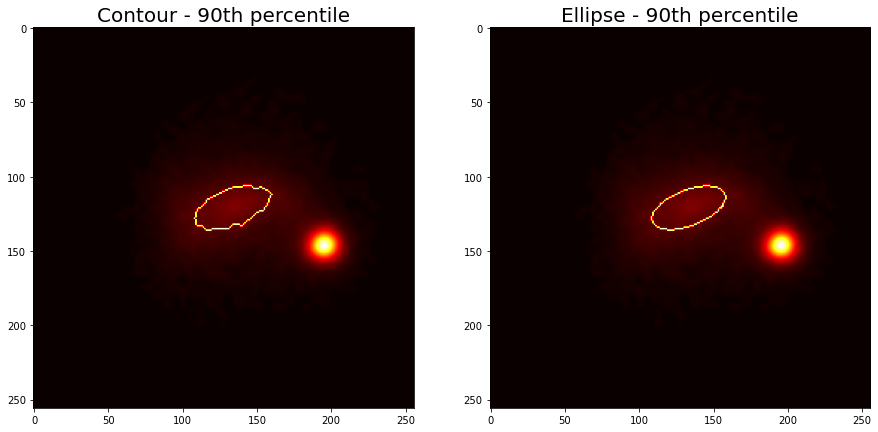

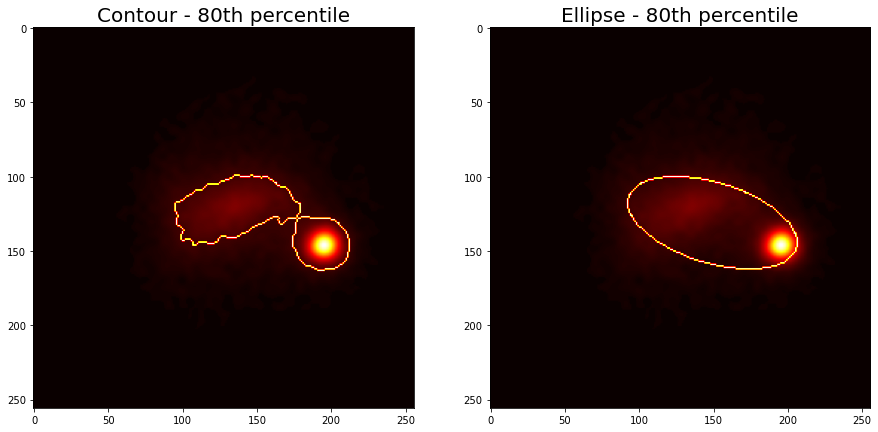

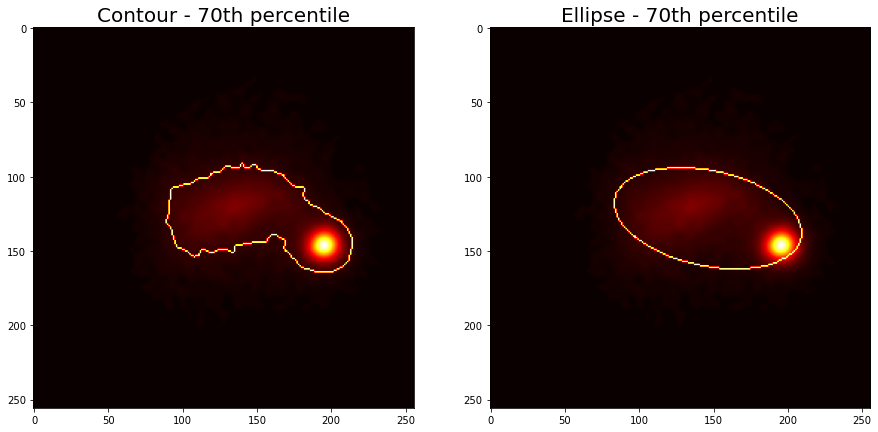

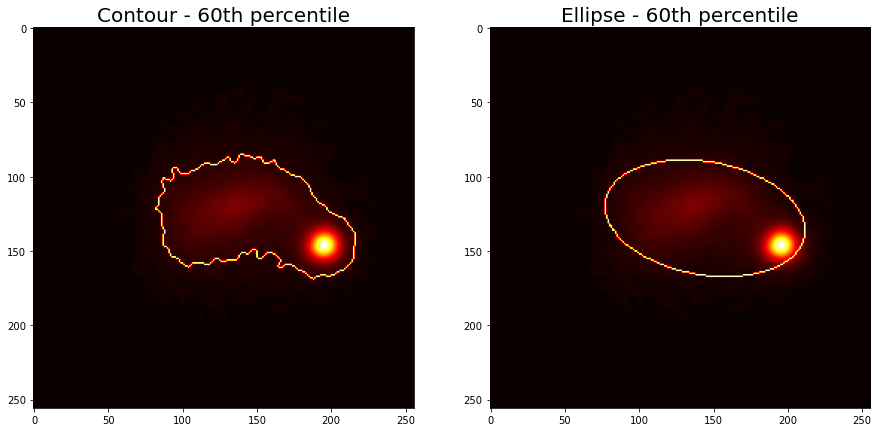

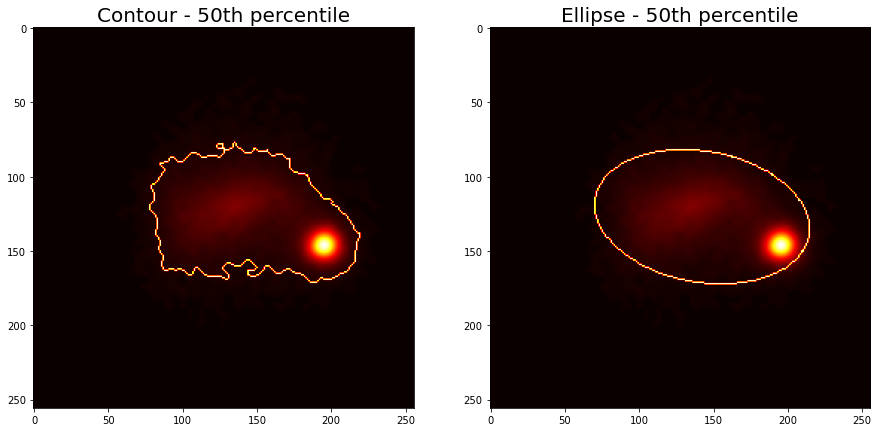

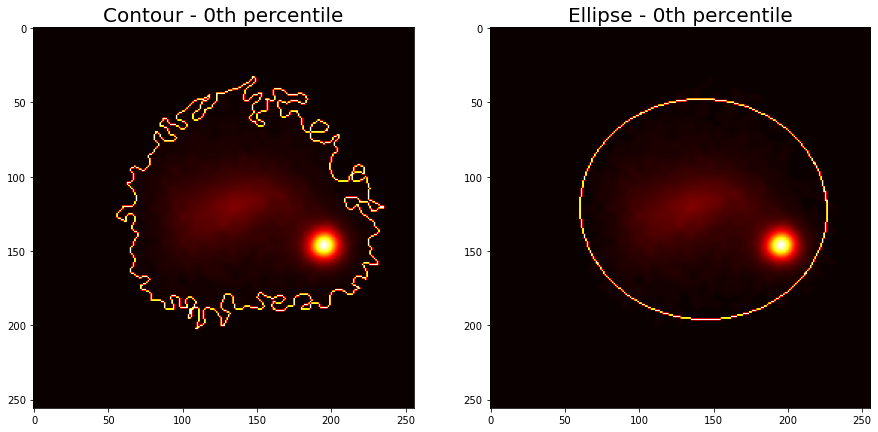

In [76]:
%matplotlib inline

for i in range(len(drawn_contours)):
        #drawn = draw_contour(all_contours[i], resize)

        f = plt.figure(figsize=(15, 15))

        f.add_subplot(1, 2, 1)
        plt.imshow(drawn_contours[i],cmap = 'hot')
        plt.gca().set_title('Contour - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

        f.add_subplot(1, 2, 2)
        plt.imshow(all_ellipses[i],cmap = 'hot')
        plt.gca().set_title('Ellipse - ' +
                        str(percentiles[i]) + 'th percentile', fontsize=20)

        plt.show(block=True)